In [ ]:
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [ ]:
zip_path = 'archive.zip'
extract_path = 'fer2013_data'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Unzipped successfully!")

Unzipped successfully!


In [ ]:
train_path = os.path.join(extract_path, 'train')
test_path = os.path.join(extract_path, 'test')

In [ ]:
train_folders = os.listdir(train_path)
test_folders = os.listdir(test_path)
print("Train Folders:", train_folders)
print("Test Folders:", test_folders)

Train Folders: ['angry', 'disgust', 'happy', 'sad', 'neutral', 'surprise', 'fear']
Test Folders: ['angry', 'disgust', 'happy', 'sad', 'neutral', 'surprise', 'fear']


In [ ]:
img_height, img_width = 48, 48
batch_size = 32

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1./255)
train_data = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training',
    shuffle=True
)
val_data = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation',
    shuffle=False
)
test_data = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
print(f"Training samples: {train_data.samples}")
print(f"Validation samples: {val_data.samples}")
print(f"Test samples: {test_data.samples}")


Training samples: 22968
Validation samples: 5741
Test samples: 7178


In [ ]:
class_labels = list(train_data.class_indices.keys())
print("Emotion classes:", class_labels)


Emotion classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


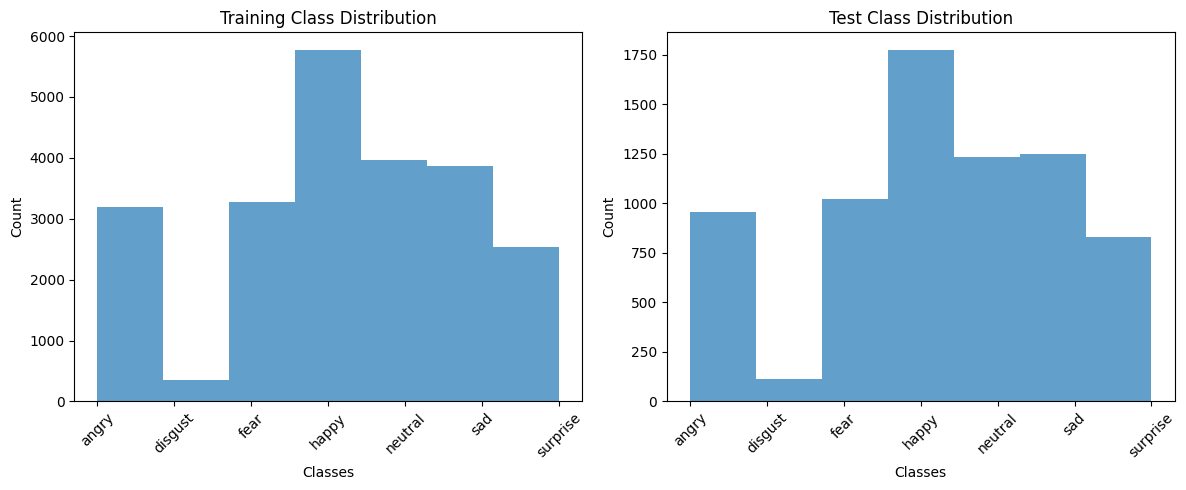

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(train_data.classes, bins=len(class_labels), alpha=0.7)
plt.title('Training Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.xticks(range(len(class_labels)), class_labels, rotation=45)
plt.subplot(1, 2, 2)
plt.hist(test_data.classes, bins=len(class_labels), alpha=0.7)
plt.title('Test Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.xticks(range(len(class_labels)), class_labels, rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1), padding='same'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(256, (2, 2), activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(class_labels), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 6, 6, 256)      │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,126,375 (19.56 MB)

 Trainable params: 5,124,391 (19.55 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
checkpoint = ModelCheckpoint(
    "best_emotion_model.keras",
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

Epoch 1/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.1952 - loss: 2.5657

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 1.95613, saving model to best_emotion_model.keras
718/718 ━━━━━━━━━━━━━━━━━━━━ 52s 53ms/step - accuracy: 0.1952 - loss: 2.5652 - val_accuracy: 0.2014 - val_loss: 1.9561 - learning_rate: 0.0010
Epoch 2/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2601 - loss: 1.8129
Epoch 2: val_loss improved from 1.95613 to 1.79078, saving model to best_emotion_model.keras
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.2601 - loss: 1.8128 - val_accuracy: 0.2994 - val_loss: 1.7908 - learning_rate: 0.0010
Epoch 3/50
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3289 - loss: 1.6806
Epoch 3: val_loss improved from 1.79078 to 1.69999, saving model to best_emotion_model.keras
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.3289 - loss: 1.6805 - val_accuracy: 0.3209 - val_loss: 1.7000 - learning_rate: 0.0010
Epoch 4/50
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3842 - loss: 1.5783
Epoch 4: val_loss improved from 1.

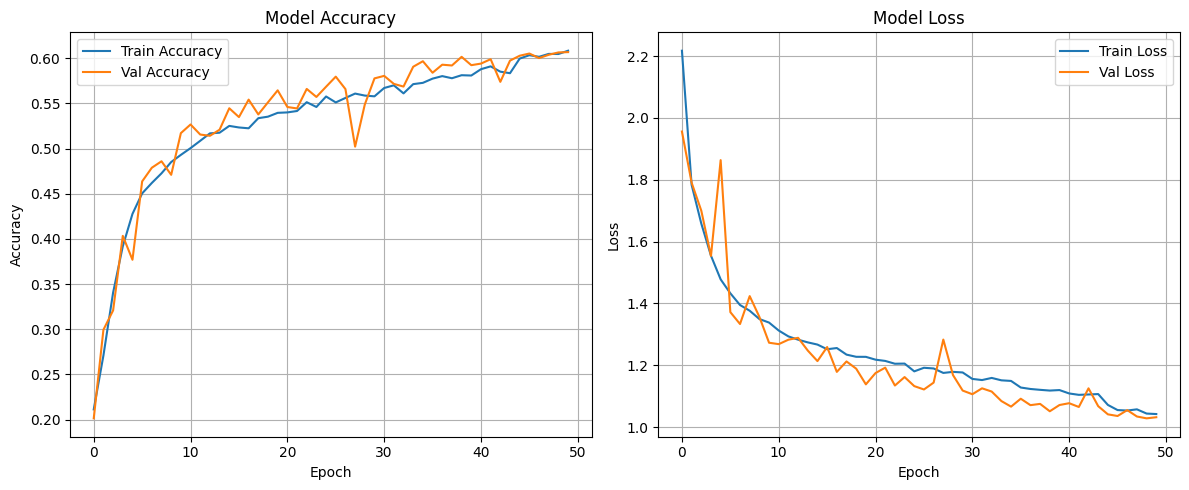

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_data, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test Accuracy: 0.6261
Test Loss: 0.9884


225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step

Classification Report:
              precision    recall  f1-score   support

       angry       0.58      0.52      0.55       958
     disgust       0.51      0.17      0.26       111
        fear       0.65      0.20      0.30      1024
       happy       0.86      0.85      0.86      1774
     neutral       0.47      0.81      0.60      1233
         sad       0.52      0.46      0.49      1247
    surprise       0.69      0.82      0.75       831

    accuracy                           0.63      7178
   macro avg       0.61      0.55      0.54      7178
weighted avg       0.64      0.63      0.61      7178



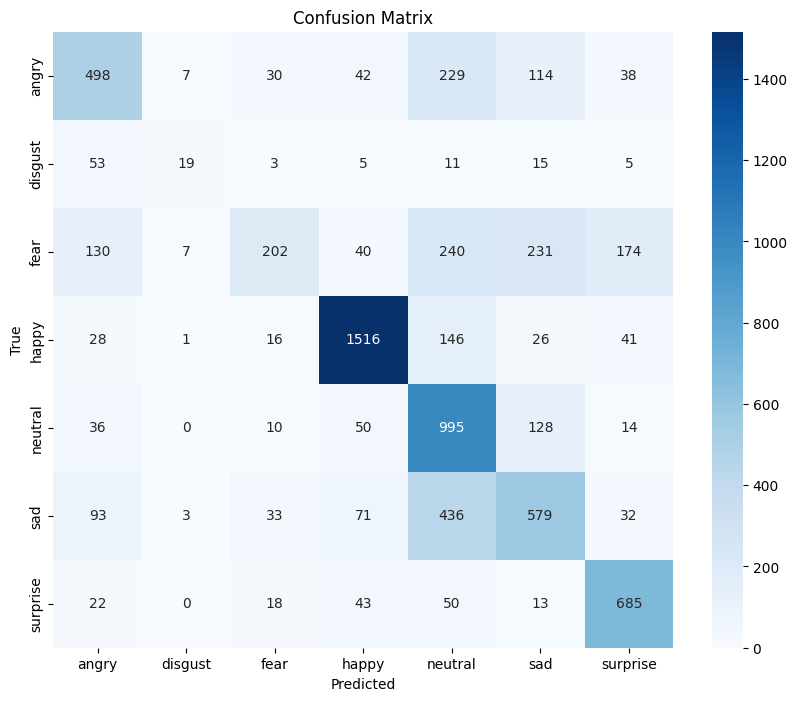

In [ ]:
test_data.reset()
predictions = model.predict(test_data, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_data.classes
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))
plt.figure(figsize=(10, 8))
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
def predict_emotion_with_confidence(model, img_path, class_labels):
    from tensorflow.keras.preprocessing import image
    img = image.load_img(img_path, target_size=(48, 48), color_mode='grayscale')
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    predictions = model.predict(img_array)
    confidence_scores = predictions[0]
    top_3_indices = np.argsort(confidence_scores)[-3:][::-1]
    print("Top 3 predictions:")
    for i, idx in enumerate(top_3_indices):
        print(f"{i+1}. {class_labels[idx]}: {confidence_scores[idx]:.3f}")

    return class_labels[np.argmax(predictions)], np.max(confidence_scores)


Testing on sample images:
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Sample 1:
True: angry, Predicted: angry
Confidence: 0.855
------------------------------


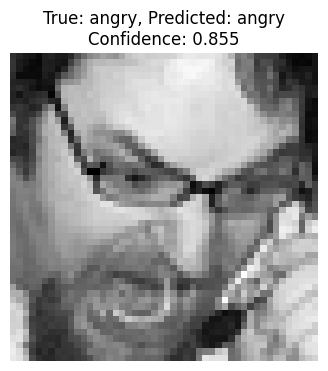

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sample 2:
True: angry, Predicted: angry
Confidence: 0.346
------------------------------


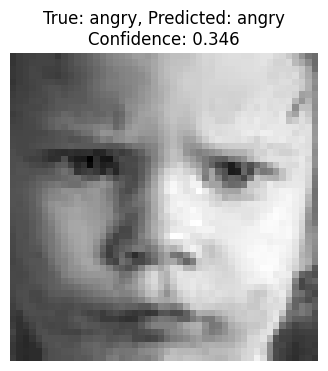

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Sample 3:
True: angry, Predicted: surprise
Confidence: 0.651
------------------------------


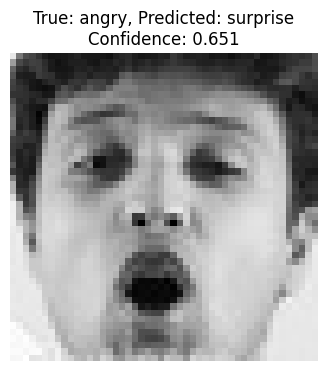

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sample 4:
True: angry, Predicted: angry
Confidence: 0.604
------------------------------


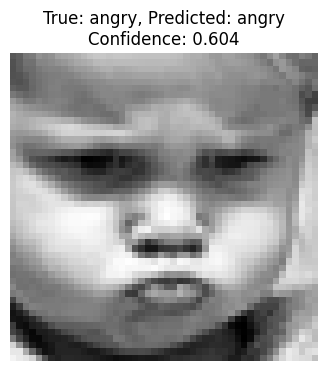

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sample 5:
True: angry, Predicted: angry
Confidence: 0.994
------------------------------


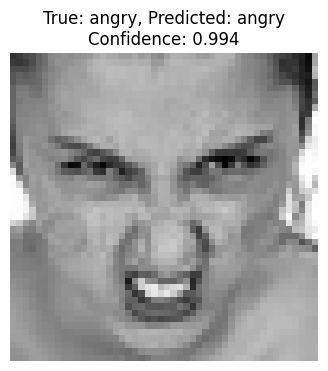

In [ ]:
print("\nTesting on sample images:")
test_data.reset()
for i in range(5):
    img_batch, label_batch = next(iter(test_data))
    img = img_batch[0]
    true_label = np.argmax(label_batch[0])
    prediction = model.predict(np.expand_dims(img, axis=0))
    predicted_label = np.argmax(prediction)
    confidence = np.max(prediction)
    print(f"Sample {i+1}:")
    print(f"True: {class_labels[true_label]}, Predicted: {class_labels[predicted_label]}")
    print(f"Confidence: {confidence:.3f}")
    print("-" * 30)
    plt.figure(figsize=(4, 4))
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"True: {class_labels[true_label]}, Predicted: {class_labels[predicted_label]}\nConfidence: {confidence:.3f}")
    plt.axis('off')
    plt.show()

In [ ]:
print("\nPer-class accuracy:")
for i, class_name in enumerate(class_labels):
    class_mask = (true_classes == i)
    class_acc = np.mean(predicted_classes[class_mask] == true_classes[class_mask])
    print(f"{class_name}: {class_acc:.3f}")


Per-class accuracy:
angry: 0.520
disgust: 0.171
fear: 0.197
happy: 0.855
neutral: 0.807
sad: 0.464
surprise: 0.824
